In [1]:
import pandas as pd
%matplotlib inline

import sys
sys.path.append('..')
import edhec_risk_kit as erk

- How to implement efficient frontier analysis in the presence and in the absence of a risk-free asset
- How to extend Markowitz analysis so as to make it consistent with real-world constraints

# The only free lunch in finance

- Say asset A has a return of 4% and a vola of 10%
- Asset B has a return of 6% and a vola of 14%
- What is the return of a combination of A and B?
  - It's *not* (5%, 12%) (unless they are *perfectly* correlated)
  - The return is the weighted average, i.e. 5%, that is true
  - But the risk depends on the correlations of the returns
    - And it can be **lower** than the lowest individual asset's return
    
    
The combined return:

$R(w_A, w_B) = w_A R_a + w_B R_b$

The combined risk:

$\sigma^2(w_A, w_B) = \sigma^2_A w^2_A + \sigma^2_B w^2_B + 2w_Aw_B\sigma_A\sigma_B\rho_{A,B}$

# Efficient frontier

In [2]:
ind = erk.get_ind_returns()

In [3]:
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


In [4]:
erk.drawdown(ind['Food'])

,Wealth,Previous Peak,Drawdown
1926-07,1.005600e+03,1.005600e+03,0.000000
1926-08,1.031645e+03,1.031645e+03,0.000000
1926-09,1.043612e+03,1.043612e+03,0.000000
1926-10,1.011678e+03,1.043612e+03,-0.030600
1926-11,1.075919e+03,1.075919e+03,0.000000
...,...,...,...
2018-08,1.260975e+07,1.316104e+07,-0.041888
2018-09,1.256940e+07,1.316104e+07,-0.044954
2018-10,1.269761e+07,1.316104e+07,-0.035212
2018-11,1.304298e+07,1.316104e+07,-0.008970


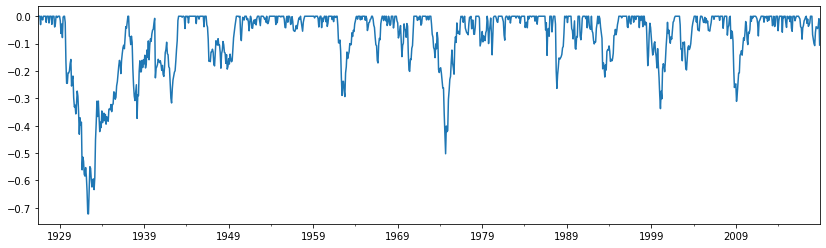

In [5]:
erk.drawdown(ind['Food'])['Drawdown'].plot.line(figsize=(14,4))

Look:

- 69% of the time we are below an all-time peak
- 28% of the time we are more than 10% below an all-time peak

In [6]:
(erk.drawdown(ind['Food'])['Drawdown'] < 0).mean()

0.6873873873873874

In [7]:
(erk.drawdown(ind['Food'])['Drawdown'] < -0.1).mean()

0.2828828828828829

----

Check: Business Equipment, Games and Mines have very high VaR, and Beer, Coal and Food comparatively low ones

In [8]:
erk.var_gaussian(ind, level=5, modified=True).sort_values().tail(3)

BusEq    0.099377
Games    0.100701
Mines    0.102782
dtype: float64

In [9]:
erk.var_gaussian(ind, level=5, modified=True).sort_values().head(3)

Beer    0.033881
Coal    0.047359
Food    0.061207
dtype: float64

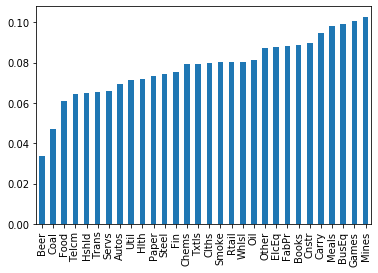

In [10]:
erk.var_gaussian(ind, level=5, modified=True).sort_values().plot.bar()

In [11]:
erk.annualize_rets(ind['Food'], 12)

0.10664913743517412

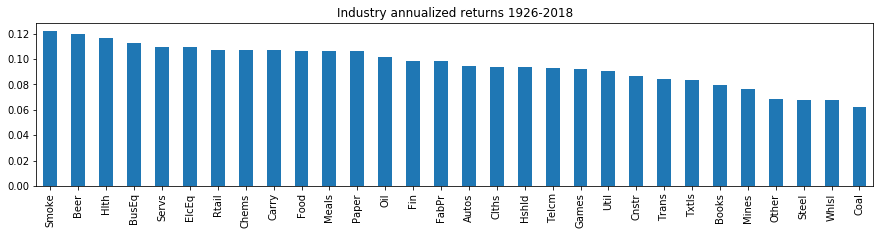

In [12]:
erk.annualize_rets(ind, 12).sort_values(ascending=False).plot.bar(
    title="Industry annualized returns 1926-2018",
    figsize=(15, 3)
)

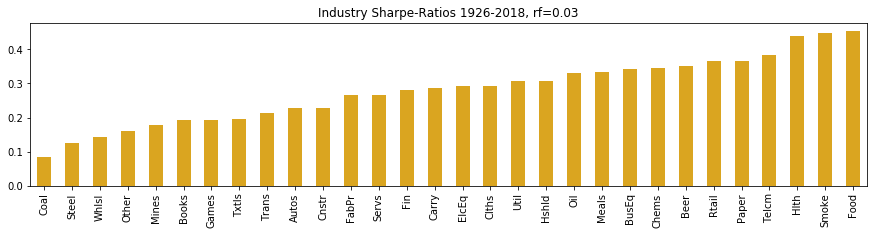

In [13]:
erk.sharpe_ratio(ind, 0.03, 12).sort_values().plot.bar(
    title="Industry Sharpe-Ratios 1926-2018, rf=0.03",
    color="goldenrod",
    figsize=(15, 3)
)

High = good, so Food, Smoke, and Healthcare have performed very well

----

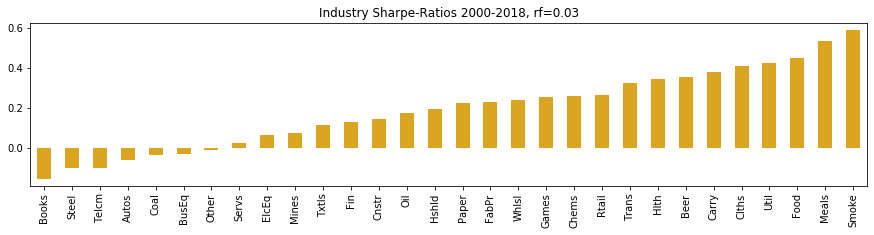

In [14]:
erk.sharpe_ratio(ind['2000':], 0.03, 12).sort_values().plot.bar(
    title="Industry Sharpe-Ratios 2000-2018, rf=0.03",
    color="goldenrod",
    figsize=(15, 3)
)

There are negative Sharpe ratios as well, of course.

**TODO** Rolling per-decade Sharpe ratios would be super cool!

# Computing the efficient frontier

**Don't look at this as a forecasting exercise; instead, we'll compute what the efficient frontier *was* in the past**

In [15]:
expected_returns = erk.annualize_rets(ind['1995':'2000'], periods_per_year=12)

In [16]:
covariance_matrix = ind['1995':'2000'].cov()